
# Instability of algorithms

In this notes we discuss an example of a *well-posed* problem that we try 
to solve using an *unstable algorithm*, thus geting a poor answer.
(We also correct the difficulty by changing the algorithm.)

However, for certain problems, "good" answers cannot be obtained by 
any algorithm because the problem is sensitive to the small errors 
made in data representation and arithmetic. 

It is important to distinguish between these two classes of pitfalls because
there are unstable algorithms and sensitive problems in nearly all branches
of numerical mathematics. Once you become aware of their symptoms, these
problems are fairly easy to diagnose.


Suppose we wish to compute the integrals 

$$I(n) = \int_0^1 x^n e^{-x} \mathrm{d}x , \quad n = 1, 2, \ldots \tag{1}$$

Integrals $I(n)$ have the following properties:

- All $I(n)$ are strictly positive, $I(n) > 0$, since the integrand is positive throughout the interval (0, 1). 

- $I(n)$ are monotonically decreasing as n is increasing: 
since $x^{n+1} < x^n$ for $0 < x < 1$, then $x^{n+1} e^{-x} < x^n e^{-x}$, 
and thus $I(n+1) < I(n)$.

We'll use those properties of $I(n)$ to check the validity of our numerical calculations.


Integrating Eq. (1) by parts, 

$$
I(n+1) = -\int_0^1 x^{n+1} \mathrm{d}(e^{-x}) =  
- \left. x^{n+1} e^{-x} \right|_0^1 + \int_0^1 e^{-x} \mathrm{d}(x^{n+1}) =
(n+1) \int_0^1 x^n e^{-x} \mathrm{d}x  - \frac{1}{e} =
(n+1) I(n) - \frac{1}{e} ,
$$

we establish the following recurrence relation:

$$I(n+1) = (n+1) I(n) - \frac{1}{e}. \tag{2}$$

In addition, we know the value of the elementary integral $I(1)$:

$$I(1) = 1 - \frac{2}{e} . \tag{3}$$

We can use recurrence relation Eq. (2) together with the initial condition Eq. (3) to calculate $I(n)$ for any $n$.


We are going to calculate the integrals $I(n)$ 
using just described recurrence algorithm. We check the accuracy 
of the calculations by comparing the values of the integrals with the ones 
obtained by the function `quadgk` from the Julia package `QuadGK`.


#### 0. 

Load required packages. 

In [1]:

using QuadGK
using PyPlot


Select the number of integrals to calculate:

In [2]:

np = 20

20


Define a helper function for the integrand:

In [3]:

integrand(x, n) = x^n * exp(-x)

integrand (generic function with 1 method)

#### 1. 

Write a function, `quadrature(m)`, that calculates the integrals I(n) 
for $n = 1, 2, ..., m$ using `quadgk` integrator and 
returns a vector of calculated integrals' values.

In [4]:

"""
     res = quadrature(m)

Evaluate the integrals I(n), Eq. (1) for n = 1:m using quadgk integrator. 
Return a vector of calculated integrals' values.
"""
function quadrature(m)
    r = zeros(m)
    for n = 1:m
        r[n] = quadgk(x -> integrand(x, n), 0.0, 1.0)[1]
    end
    return r
end

quadrature


Calculate the integrals using `quadrature` function:

In [5]:

res_q = quadrature(np);


#### 2.

Write a function, `recurrence(m)`, that calculates the integrals I(n) 
for $n = 1, 2, ..., m$ using the recurrence relations Eq. (2) and 
returns a vector of calculated integrals' values.

In [6]:

"""
     res = recurrence(m)

Evaluate the integrals I(n), Eq. (1) for n = 1:m using recurrence relations Eq. (2). 
Return a vector of calculated integrals' values.
"""
function recurrence(m)
    r = zeros(m)
    r[1] = 1.0 - 2*exp(-1.0)
    for n = 1:(m-1)
        r[n+1] = (n + 1) * r[n] - exp(-1.0)
    end
    return r
end 

recurrence


Calculate the integrals using `recurrence` function:

In [7]:

res_r = recurrence(np);


#### 3.

In the same figure, plot the results calculated by both functions.  Provide the grid, axes labels, title, and the legend for your graph.

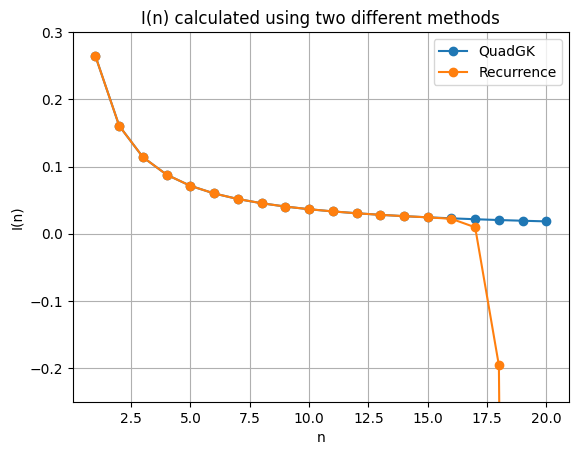

In [8]:

plot(1:np, res_q, marker="o", label="QuadGK")
plot(1:np, res_r, marker="o", label="Recurrence")
ylim(-0.25, 0.3)
legend()
grid(true)
title("I(n) calculated using two different methods")
xlabel("n")
ylabel("I(n)");


Something is obviously wrong: the values of $I(n)$ calculate by recurrence algorithm are not positive! 


#### 4.

To see what is exactly wrong, plot the absolute error of evaluation of $I(n)$, 
assuming that `quadgk` integrator produces accurate results. 

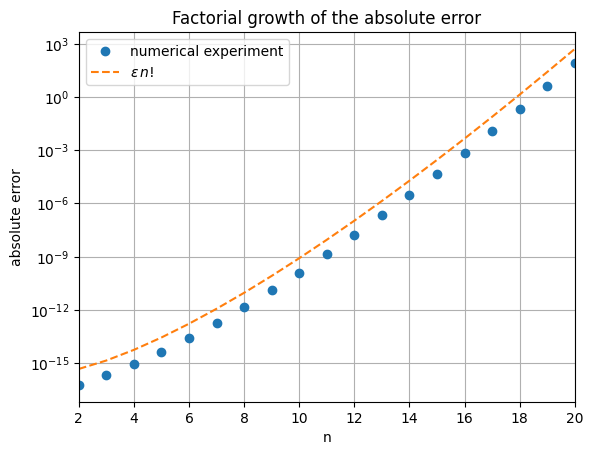

In [9]:

semilogy(2:np, (abs.(res_q .- res_r))[2:np], marker="o", label="numerical experiment", linestyle="none")
semilogy(2:np, eps() * factorial.(2:np), linestyle="dashed", label=L"\epsilon \, n!")
grid(true)
legend()
xlim(2,20)
xlabel("n")
ylabel("absolute error")
title("Factorial growth of the absolute error");


We the that the absolute error in $I(n)$ grows as $n$ factorial, $n!$. 
What caused the large error? Observe that the only roundoff error made in
the above calculations was in $I(1)$ where $1 - \frac{2}{e}$ was rounded 
introducing an error of the order of machine epsilon. To see how the error 
of about $10^{-16}$ in $I(1)$ becomes so large,
notice that it is multiplied by $2$ in the calculation of $I(2)$, then the error in
$I(2)$ is multiplied by $3$ in computing $I(3)$, and so on. Thus, the error in $I(20)$
is exactly the error in $I(1)$ multiplied by $2 \times 3 \times 4 \ldots \times 20 = 20!$ or about $2.4 \times 10^{18}$.
This enormous magnification of the error is a result of the algorithm we choose to use.


#### 5.

How can we modify the algorithm to avoids this instability?
If we rewrite the recurrence relation Eq. (2) as

$$I(n) = \frac{I(n+1) + \frac{1}{e}}{n+1}, \qquad n = \ldots, 4, 3, 2, 1,$$

then at each stage of the calculation, the error in $I(n)$ is decreased by a factor
of 1/(n+1). So if we start with a value for some $I(k)$ and work backbackwards, 
any initial error or rounding errors which occur will be decreased at
each step. This is called a *stable algorithm*.

In [ ]:

"""
     res = recurrence_reverse(m, extra)

Evaluate the integrals I(n), Eq. (1) for n = 1:(m+extra) using the "reverse"
recurrence relation I(n) = (I(n+1) - 1/e)/(n+1), with the initial condition 
I(m+extra) = 0.
Return a vector of calculated integrals' values discarding the last `extra` elements
"""
function recurrence_reverse(m, mextra)
    r = zeros(m+mextra)
    r[end] = 0.0
    for n = (m+mextra-1):-1:1
        r[n] = (r[n+1] + exp(-1))/(n+1)
    end
    return r[1:m]  # discard the last mextra elements
end 


Calculate the integrals using `recurrence_reverse` function:

In [ ]:

res_rr = recurrence_reverse(np, 11);


Plot the absolute error of evaluation of $I(n)$ using the reverse recurrence: 

In [ ]:

plot(1:np, (abs.(res_q .- res_rr)), marker="o", label="numerical experiment", linestyle="none")
grid(true)
xlim(2,20)
xlabel("n")
ylabel("absolute error")
title("Improved recurrence algorithm");


Notice that errors now are of order of machine precision which is the best we can achieve in numerical calculations. 